In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import jax
import jax.numpy as jnp
from jax import jit

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

## Setup

In [2]:
# ===============================================
# PLATE PARAMETERS
# -----------------------------------------------
n_retractors = 168
r = 102.5 # mm, half of 205mm field
n_tiers = 3
n_fibres = n_retractors * n_tiers

# Retractor coordinates & constraints
angles = jnp.linspace(0, 2*jnp.pi, n_retractors, endpoint=False) # placement of fibres
retractor_x = jnp.asarray(r * jnp.cos(angles))
retractor_y = jnp.asarray(r * jnp.sin(angles))
fibre_span_allowed = jnp.asarray([r*0.4, r*0.7 , r*1.3]) # for tiers 0,1,2 (low-high)
phi_max = jnp.deg2rad(14)  # max bend angle

# Button vertices in local fibre-target coordinates
# box of 9mm lengh, 2mm width
button_vertices_local = jnp.array([
    [-1,  6],
    [ 1,  6],
    [ 1, -3],
    [-1, -3],
])

# Minimum possible target separation
min_sep = 2 # mm; min. distance of separation below which buttons overlap

# -----------------------------------------------
# FIELD PARAMETERS
# -----------------------------------------------
n_targets = 1400 # 1400

# ===============================================

## Function definitions

In [3]:
# Sample random target dist., uniform over circular sky area
def rand_targets(R, n):
    """
    R = radius of disc
    n = number of targets to generate
    """
    key = jax.random.PRNGKey(0)
    key_p, key_q = jax.random.split(key)
    p = jax.random.uniform(key_p, shape=(n,))
    q = jax.random.uniform(key_q, shape=(n,))
    r = R * jnp.sqrt(p)
    theta = 2*jnp.pi*q

    return r * jnp.cos(theta), r * jnp.sin(theta)

# Indexing: assigning fibre IDs based on retractor and tier IDs
def fibre_id(retractor_id, tier_id): # Fibre ID from retractor & tier id
    if tier_id < 0 or tier_id >= n_tiers:
        raise ValueError("Invalid tier_id")
    return retractor_id * n_tiers + tier_id

# Indexing: retrieving retractor and tier IDs from fibre ID
def fibre_rt(fibre_id):
    r_id = fibre_id // n_tiers
    t_id = fibre_id % n_tiers
    return r_id, t_id # Retractor ID & tier ID from fibre ID

@jit
def TF_reach_matrix(px,py):
    """
    Vectorized function to generate matrix for allowed target-fibre pairs given reach & bend constraints.
    """
    fibre_ids = jnp.arange(n_fibres)      # (F,)
    r_ids = fibre_ids // n_tiers          # (F,)
    t_ids = fibre_ids % n_tiers           # (F,)

    rx = retractor_x[r_ids]               # (F,)
    ry = retractor_y[r_ids]               # (F,)
    tier_span = fibre_span_allowed[t_ids] # (F,) / FOR EACH FIBRE

    pos_r = jnp.stack([rx, ry], axis=1)  # (F,2) (x,y) pos. for each retractor
    pos_r_norm_inward = - pos_r / jnp.linalg.norm(pos_r, axis=1, keepdims=True) # (F,) : unit vector in retractor-origin direction

    vx = px[None, :] - rx[:, None]     # (F, T) Broadcast dimensions!! So cool!
    vy = py[None, :] - ry[:, None]     # (F, T)
    v_len = jnp.sqrt(vx**2 + vy**2)   # (F, T)

    ux = vx / v_len   # (F, T)
    uy = vy / v_len   # (F, T)

    # Dot product between norm (inward) from retractor & unit vector from retractor to target
    dot = (ux * pos_r_norm_inward[:, 0:1] + uy * pos_r_norm_inward[:, 1:2])     # (F, T)

    # Angle between norm @ rectractor & vector to target
    ang = jnp.arccos(dot)       # (F, T)

    # Allowed span per fibre
    span_allowed = tier_span[:, None]  # (F, 1)

    # Check reachability
    allowed = (v_len <= span_allowed) & (ang <= phi_max)  # (F, T) bool

    return allowed

# Get targets for a single fibre form *allowed*
# allowed_all[fibre] # (T,) bool

@jit
def all_button_vertices(px, py, allowed):
    """
    Compute button polygon vertices for all fibre-target combinations.

    px, py: (T,)
    allowed: (F, T) bool - True if fibre f can reach target t
    returns: vertices of shape (F, T, 4, 2)
             vertices[f, t, k, :] = [x, y] of vertex k (k=0..3)
             entries are NaN where allowed[f, t] is False.
    """
    R = allowed.shape[0]             # n_retractors
    T = allowed.shape[1]             # n_targets

    # Get fiber IDs from Retractor IDs
    fibre_ids = jnp.arange(R)              # (R,)
    r_ids = fibre_ids // n_tiers          # (F,)

    # Broadcast fibre and target positions to (F, T)
    rx = retractor_x[r_ids, None]               # (F,1)
    ry = retractor_y[r_ids, None]               # (F,1)
    # rx = retractor_x[:, None]         # (F, 1)
    # ry = retractor_y[:, None]         # (F, 1)

    tx = px[None, :]                  # (1, T)
    ty = py[None, :]                  # (1, T)

    # Direction from retractor to target
    vx = tx - rx                      # (F, T)
    vy = ty - ry                      # (F, T)
    phi = jnp.arctan2(vy, vx)         # (F, T)
    theta = phi + jnp.pi / 2          # (F, T) FIRST ATTEMPT WAS PERP.?

    c = jnp.cos(theta)                # (F, T)
    s = jnp.sin(theta)                # (F, T)

    # Local vertices: (4,2) -> separate x,y components
    bx = button_vertices_local[:, 0]  # x-components (4,)
    by = button_vertices_local[:, 1]  # y-components (4,)

    # Broadcast local vertices to (F, T, 4)
    bx_broadcast = bx[None, None, :]          # (1, 1, 4)
    by_broadcast = by[None, None, :]          # (1, 1, 4)

    # Rotate each vertex for each (fibre, target)
    # ROTATION from (x,y) to (x',y') such that : x' = c*x - s*y & y' = s*x + c*y
    # Broadcast cos & sin from (F,T,1) to get final dimensions of (F,T,4) - rotated vertices for each Fibre-Target combination
    x_rot = c[:, :, None] * bx_broadcast - s[:, :, None] * by_broadcast   # (F, T, 4)
    y_rot = s[:, :, None] * bx_broadcast + c[:, :, None] * by_broadcast  # (F, T, 4)

    # Translate vertices to target position (tx, ty) !
    x_vertex = px[None, :, None] + x_rot                  # (F, T, 4)
    y_vertex = py[None, :, None] + y_rot                  # (F, T, 4)

    # Apply to reachability matrix: only return vertices for possible T-F combinations
    mask = allowed[:, :, None]                            # (F, T, 1)
    # print(rx.shape)
    # print(bx_broadcast.shape)
    # print(c.shape)
    # print(x_rot.shape)
    # print(x_vertex.shape)
    # print(mask.shape)
    x_vertex = jnp.where(mask, x_vertex, jnp.nan) # jnp.where: vlues drawn from x_vertex if mask (reach!) is True, NaN if not
    y_vertex = jnp.where(mask, y_vertex, jnp.nan)

    # Return final array of vertices
    vertices = jnp.stack([x_vertex, y_vertex], axis=-1)   # x_vertex, y_vertex have shape (F, T, 4), stack axis=-1 creates new rightmost axis! 
                                                          # Final shape: (F, T, 4, 2)
    return vertices

@jax.jit
def compute_target_bboxes(vertices):
    # Transform vertices to per-target
    vertices_T = jnp.transpose(vertices, (1, 0, 2, 3))      # (T, F, 4, 2)
    vertices_T = vertices_T.reshape(vertices_T.shape[0], -1, 2)   # (T, F*4, 2) : ALL button verties for each target

    xmin = jnp.nanmin(vertices_T[..., 0], axis=1) # min of all x-coords
    xmax = jnp.nanmax(vertices_T[..., 0], axis=1) # max  "  "     "
    ymin = jnp.nanmin(vertices_T[..., 1], axis=1) # min of all y-coords
    ymax = jnp.nanmax(vertices_T[..., 1], axis=1) # max  "  "     "

    footprint_valid = jnp.isfinite(xmin) # False target has no reachable fibres at all
    return xmin, ymin, xmax, ymax, footprint_valid

@jax.jit
def compute_bbox_overlap(xmin, ymin, xmax, ymax, footprint_valid):
    # Broadcast bounds to compare pair-wise bounding box coordinates
    xmin_i = xmin[:, None];  xmin_j = xmin[None, :] # (T, 1) & (1, T) respectively
    xmax_i = xmax[:, None];  xmax_j = xmax[None, :]
    ymin_i = ymin[:, None];  ymin_j = ymin[None, :]
    ymax_i = ymax[:, None];  ymax_j = ymax[None, :]

    # Boxes overlap IF the min of one vertex is less than the max of the other in both X and Y
    overlap = (
        (xmax_i >= xmin_j) &
        (xmax_j >= xmin_i) &
        (ymax_i >= ymin_j) &
        (ymax_j >= ymin_i)
    ) # Boolean array shape (T,T)

    # Consider which targets have NO valid F-T connections
    valid_i = footprint_valid[:, None] # (T, 1)
    valid_j = footprint_valid[None, :] # (1, T)

    overlap = overlap & valid_i & valid_j # combine bool arrays - only where all are True is True returned

    # Remove diagonal entries (self-overlap)
    T = xmin.shape[0]
    overlap = overlap & (~jnp.eye(T, dtype=bool)) # Set all (i,i) entries to False

    # Symmetrize - keep only upper triangle as in Terret (2014)
    overlap = jnp.triu(overlap, k=1) # keep upper triangle
    overlap = overlap | overlap.T # mirror to lower

    return overlap

@jax.jit
def always_collide(px, py, reachable_Ts, min_sep):
    # Get target-target separation via broadcasting
    xi = px[:, None]      # (T, 1)
    yi = py[:, None]      # (T, 1)
    dx = xi - xi.T        # (T, T)
    dy = yi - yi.T        # (T, T)
    d2 = dx**2 + dy**2    # (T, T) squared distances between targets

    # Ignore self-distances
    T = px.shape[0] # n_targets
    d2 = d2 + jnp.eye(T) * jnp.inf # add identity matrix scaled by inf to distances**2

    # Check for separation-based collision
    collide = jnp.sqrt(d2) < min_sep # (T, T) bool

    # Limit to target pairs that are both reachable by some fibre
    both_reachable = reachable_Ts[:, None] & reachable_Ts[None, :] # BROADCAST (T, T) bool
    always_collide = collide & both_reachable # reachable pairs that always collide

    # Keep upper triangle
    always_collide = jnp.triu(always_collide, k=1) # return only upper triangle
    always_collide = always_collide | always_collide.T # force symmetry
    always_collide = jnp.where(jnp.eye(T, dtype=bool), False, always_collide) # force diagonal = False

    return always_collide

# Function to check segment-segment overlap
def seg_seg_intersect(p, r, q, s):
    # Input: p,r,q,s are (...,2) arrays representing segments p->p+r and q->q+s
    # Output: boolean array of shape (...) indicating whether segments intersect

    cross = lambda a, b: a[..., 0]*b[..., 1] - a[..., 1]*b[..., 0] # 2D cross product

    rxs = cross(r, s)
    q_p = q - p
    q_pxr = cross(q_p, r) # is separation of q & p || to r (or s)? If yes: vectors are not just parallel but collinear

    # parallel or collinear
    parallel = jnp.isclose(rxs, 0)
    # collinear = jnp.isclose(q_pxr, 0) # Is this necessary??

    # For non-parallel, find t,u parameters at intersection. If both ∈ [0,1] POI ∈ of both segments
    t = cross(q_p, s) / rxs
    u = cross(q_p, r) / rxs

    # Intersect: True where NOT parallel, and t,u both ∈ [0,1]
    intersect = (~parallel) & (t >= 0) & (t <= 1) & (u >= 0) & (u <= 1)
    return intersect


In [4]:
@jax. jit
def compute_path_bboxes(px, py, retractor_x, retractor_y, r_id_for_fibre, allowed):
    """
    Compute bounding boxes for all fibre segments reaching each target.
    """
    F, T = allowed.shape # n_fibres, n_targets

    # Retractor positions for each fibre
    rx_f = retractor_x[r_id_for_fibre] # (F,)
    ry_f = retractor_y[r_id_for_fibre] # (F,)

    rx = rx_f[:, None] # (F, 1)
    ry = ry_f[:, None] # (F, 1)

    # All target positions for all fibres (tx[f,t] = px[t])
    tx = jnp.broadcast_to(px[None, :], (F, T))
    ty = jnp.broadcast_to(py[None, :], (F, T))

    # Segment bounding boxes for each (F,T) - either bounded by target or 
    seg_xmin = jnp.minimum(tx, rx)
    seg_xmax = jnp.maximum(tx, rx)
    seg_ymin = jnp.minimum(ty, ry)
    seg_ymax = jnp.maximum(ty, ry)

    # Mask with allowed fibres; unreachable -> ignore
    big = 1e30  # large number
    seg_xmin = jnp.where(allowed, seg_xmin, big)
    seg_ymin = jnp.where(allowed, seg_ymin, big)
    seg_xmax = jnp.where(allowed, seg_xmax, -big)
    seg_ymax = jnp.where(allowed, seg_ymax, -big)

    # Take min/max over fibres for each target
    path_xmin = jnp.min(seg_xmin, axis=0)  # (T,)
    path_ymin = jnp.min(seg_ymin, axis=0)
    path_xmax = jnp.max(seg_xmax, axis=0)
    path_ymax = jnp.max(seg_ymax, axis=0)

    return path_xmin, path_ymin, path_xmax, path_ymax

@jax.jit
def compute_fibre_segments(px, py, retractor_x, retractor_y, r_id_for_fibre, allowed):
    """
    Compute fibre segments for all fibre-target combinations.
    Return: 
    start: (F, T, 2) array of segment start points (target pos)
    vector:   (F, T, 2) vector of fibre path (from retractor to target)
    """
    F, T = allowed.shape

    # target positions: (T, 2)
    target_pos = jnp.stack([px, py], axis=-1)          # (T, 2)
    # broadcast to (F, T, 2)
    start = jnp.broadcast_to(target_pos[None, :, :], (F, T, 2)) # Target positions for all fibres # (F, T, 2)

    # retractor positions per fibre: (F,)
    rx = retractor_x[r_id_for_fibre]
    ry = retractor_y[r_id_for_fibre]

    end = jnp.stack([rx[:, None], ry[:, None]], axis=-1)  # (F, 1, 2)
    # For each fibre, end[fibre, 0, :] = (retractor_x[f], retractor_y[f])

    # Direction from 
    vector = end - start  # (F, T, 2)

    # Mask unreachable fibre–target pairs with NaNs so they never intersect
    mask = allowed[..., None]  # (F, T, 1)
    start = jnp.where(mask, start, jnp.nan)
    vector = jnp.where(mask, vector, jnp.nan)

    return start, vector

@jax.jit
def fibre_collision_block_padded(target_vertices, target_fibre_start, target_fibre_dir, target_fibre_mask, t1, t2):
    """
    Check for fibre-fibre collisions between two target blocks t1 and t2.
    target_vertices: (T, F, 4, 2) button vertices for each target-fibre pair
    target_fibre_start: (T, F, 2) fibre start points for each target-fibre pair
    target_fibre_dir: (T, F, 2) fibre direction vectors for each target-fibre pair
    target_fibre_mask: (T, F) bool mask indicating valid fibre-target pairs

    t1, t2: target indices to check

    Returns:
    collision_matrix: (F1, F2) bool array indicating collisions between fibres of target t1 and t2
    """
    verts_i = target_vertices[t1]  # (max_F, 4, 2)
    verts_j = target_vertices[t2]  # (max_F, 4, 2)

    edges_i = jnp.roll(verts_i, -1, axis=1) - verts_i  # (max_F, 4, 2)
    edges_j = jnp.roll(verts_j, -1, axis=1) - verts_j  # (max_F, 4, 2)

    mask_i = target_fibre_mask[t1]  # (max_F,)
    mask_j = target_fibre_mask[t2]  # (max_F,)

    # Ceck for button-button intersections
    p_bb = verts_i[:, None, :, None, :]  # (max_F, 1, 4, 1, 2)
    r_bb = edges_i[:, None, :, None, :]
    q_bb = verts_j[None, :, None, :, :]  # (1, max_F, 1, 4, 2)
    s_bb = edges_j[None, :, None, :, :]

    intersects_bb = seg_seg_intersect(p_bb, r_bb, q_bb, s_bb)  # (max_F, max_F, 4, 4)
    button_intersect = jnp.any(intersects_bb, axis=(2, 3))             # (max_F, max_F)

    # Fibre from t1 vs button from t2
    # fetch fibre data for target t1
    start_i = target_fibre_start[t1]  # (max_F, 2)
    dir_i   = target_fibre_dir[t1]    # (max_F, 2)

    # Fetch fibre segments from data for target t1 as p -> p+r
    p_fb1 = start_i[:, None, None, :]  # (max_F, 1, 1, 2)
    r_fb1 = dir_i[:, None, None, :]
    # Fetch button edges for target t2, as q -> q+s
    q_fb1 = verts_j[None, :, :, :]     # (1, max_F, 4, 2)
    s_fb1 = edges_j[None, :, :, :]

    intersects_fb1 = seg_seg_intersect(p_fb1, r_fb1, q_fb1, s_fb1)  # (max_F, max_F, 4)
    f1_on_b2 = jnp.any(intersects_fb1, axis=2)          # (max_F, max_F)

    # fibre from t2 vs button from t1
    # Fetch fibre data for target t2
    start_j = target_fibre_start[t2]  # (max_F, 2)
    dir_j   = target_fibre_dir[t2]    # (max_F, 2)

    p_fb2 = start_j[None, :, None, :]  # (1, max_F, 1, 2)
    r_fb2 = dir_j[None, :, None, :]
    q_fb2 = verts_i[:, None, :, :]     # (max_F, 1, 4, 2)
    s_fb2 = edges_i[:, None, :, :]

    intersects_fb2 = seg_seg_intersect(p_fb2, r_fb2, q_fb2, s_fb2)  # (max_F, max_F, 4)
    f2_on_b1 = jnp.any(intersects_fb2, axis=2)          # (max_F, max_F)

    # --- Combine all collision modes ---------------------------------
    block = button_intersect | f1_on_b2 | f2_on_b1    # (max_F, max_F)

    # Mask out padded fibres
    valid_i = mask_i[:, None]  # (max_F, 1)
    valid_j = mask_j[None, :]  # (1, max_F)
    valid_pair = valid_i & valid_j

    block = block & valid_pair

    return block
    
@jax.jit
def batch_collision_blocks(target_vertices, target_fibre_start, target_fibre_dir, 
    target_fibre_mask,t1_batch, t2_batch):
    def one_pair(t1, t2):
        return fibre_collision_block_padded(
            target_vertices, target_fibre_start, target_fibre_dir,
            target_fibre_mask, t1, t2
        )
    return jax.vmap(one_pair)(t1_batch, t2_batch)  # (B, max_F, max_F)

## Collision Matrix

In [5]:
# Fetch fibre and tier IDs for all fibres
fibre_ids = jnp.arange(n_fibres)              # (F,)
r_id_for_fibre = fibre_ids // n_tiers         # (F,)
t_id_for_fibre = fibre_ids % n_tiers          # (F,)

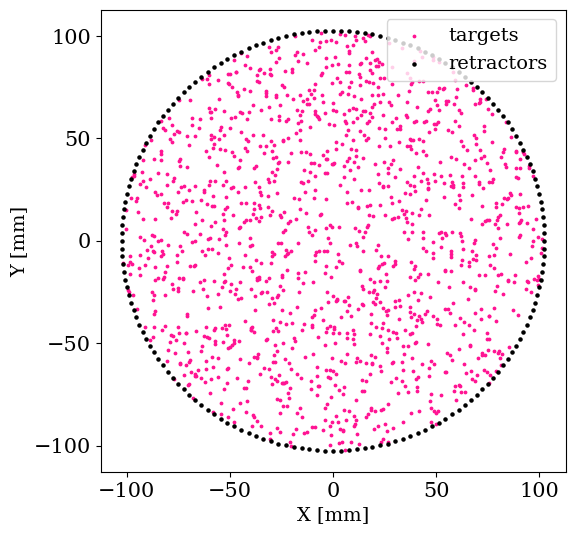

In [6]:
# Generate random targets
px,py = rand_targets(r, n_targets)
plt.figure(figsize=(6,6))
plt.scatter(px,py, s=3, c='deeppink', label='targets')
plt.scatter(r*np.cos(angles), r*np.sin(angles), c='k', s=5, label='retractors')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.legend()
plt.show()
plt.close()

In [7]:
allowed = TF_reach_matrix(px,py)
reachable_Ts = jnp.any(allowed, axis=0) # collabse fibre dimension, check if ANY fibre can reach a given target

In [8]:
always_collide_mat = always_collide(px, py, reachable_Ts, min_sep)

In [9]:
vertices = all_button_vertices(px, py, allowed)

In [10]:
# NEW 

xmin, ymin, xmax, ymax, footprint_valid = compute_target_bboxes(vertices)

path_xmin, path_ymin, path_xmax, path_ymax = compute_path_bboxes(
    px, py,
    retractor_x, retractor_y,
    r_id_for_fibre,
    allowed,
)

# Broadcast to (T, T)
# FIBRE PATH
pxmin = path_xmin[:, None]
pymin = path_ymin[:, None]
pxmax = path_xmax[:, None]
pymax = path_ymax[:, None]

# BUTTON FOOTPRINT
fxmin = xmin[None, :]
fymin = ymin[None, :]
fxmax = xmax[None, :]
fymax = ymax[None, :]

# Path(A) vs Foot(B)
pathA_hits_footB = (
    (pxmin <= fxmax) &
    (pxmax >= fxmin) &
    (pymin <= fymax) &
    (pymax >= fymin)
)

# Symmetric condition: (path(B) vs foot(A)) == transpose
path_bbox_overlap = pathA_hits_footB | pathA_hits_footB.T

# ignore self-pairs
path_bbox_overlap = path_bbox_overlap & (~jnp.eye(path_bbox_overlap.shape[0], dtype=bool))


In [11]:
bbox_overlap = compute_bbox_overlap(xmin, ymin, xmax, ymax, footprint_valid)
needs_fibre_level = (~always_collide_mat) & (bbox_overlap | path_bbox_overlap) # do NOT always collide, and have overlapping footprints OR path/footprint overlaps


print("Pairs needing fibre-level checks:", int(needs_fibre_level.sum()/2))

Pairs needing fibre-level checks: 298416


In [12]:
edges = jnp.roll(vertices, shift=-1, axis=2) - vertices  # (F, T, 4, 2)


In [13]:
# NEW

# Compute start and direction (p, p+r_vector) for all fibre alignments
fibre_start, fibre_dir = compute_fibre_segments(
    px, py,
    retractor_x, retractor_y,
    r_id_for_fibre,
    allowed
)

# allowed: JAX array (F, T)
allowed_np = np.array(allowed)  # (F, T)

# Python list: for each target t, the array of fibre indices that can reach it
reachable_fibres_per_target = [
    np.where(allowed_np[:, t])[0].astype(np.int32)
    for t in range(allowed_np.shape[1])
]

# Average number of fibres per target
avg_nfib = np.mean([len(fibs) for fibs in reachable_fibres_per_target])
print("Average fibres per target:", avg_nfib)

# max. fibres per target in field
max_F = max(len(fibs) for fibs in reachable_fibres_per_target)
print("Max fibres per target:", max_F)

n_targets = allowed_np.shape[1]

# Padded fibre ID table: (T, max_F), and mask
target_fibre_ids  = -np.ones((n_targets, max_F), dtype=np.int32)
target_fibre_mask = np.zeros((n_targets, max_F), dtype=bool)

for t, fibs in enumerate(reachable_fibres_per_target):
    n = min(len(fibs), max_F)
    target_fibre_ids[t, :n]  = fibs[:n]
    target_fibre_mask[t, :n] = True

# Build per-target padded geometry (always same dimension!!) from existing vertices, fibre_start, fibre_dir
# Fixed length to vectorize in JAX later
vertices_np = np.array(vertices) # (F, T, 4, 2)
fibre_start_np = np.array(fibre_start) # (F, T, 2)
fibre_dir_np = np.array(fibre_dir) # (F, T, 2)

target_vertices = np.zeros((n_targets, max_F, 4, 2), dtype=vertices_np.dtype) # EMPTY ARRAYS
target_fibre_start = np.zeros((n_targets, max_F, 2), dtype=fibre_start_np.dtype)
target_fibre_dir = np.zeros((n_targets, max_F, 2), dtype=fibre_dir_np.dtype)

for t in range(n_targets):
    # Fill in fibre ID data for target T, if any
    ids = target_fibre_ids[t]
    valid = ids >= 0
    if np.any(valid):
        target_vertices[t, valid, :, :] = vertices_np[ids[valid], t, :, :]
        target_fibre_start[t, valid, :] = fibre_start_np[ids[valid], t, :]
        target_fibre_dir[t, valid, :] = fibre_dir_np[ids[valid], t, :]

# PADDED ARRAYS
target_vertices_j = jnp.array(target_vertices)
target_fibre_start_j = jnp.array(target_fibre_start)
target_fibre_dir_j = jnp.array(target_fibre_dir)
target_fibre_mask_j = jnp.array(target_fibre_mask)

Average fibres per target: 29.4
Max fibres per target: 168


In [14]:
from tqdm import tqdm

# Only keep each unordered pair once (upper triangle) - TERRET (2014) approach
needs_fibre_level_np = np.array(needs_fibre_level)
pairs_i, pairs_j = np.where(np.triu(needs_fibre_level_np, k=1)) # k=1 specifies that we want to keep everything from the upper triangle only (above main diagonal)
pairs = np.stack([pairs_i, pairs_j], axis=1).astype(np.int32) # list of all UNIQUE pairs to send to fibre-level checks

print("Unique pairs needing fibre-level checks:", len(pairs))

collision_matrix = {}

B = 256  # batch size: # targets to process per call

for i in tqdm(range(0, len(pairs), B), desc="Building fibre-level collision blocks (batched)"):
    batch = pairs[i:i+B]
    t1_batch = jnp.array(batch[:, 0]) # target indices for first target in each pair
    t2_batch = jnp.array(batch[:, 1]) # target indices for second target in each pair

    blocks_full = batch_collision_blocks(
        target_vertices_j,
        target_fibre_start_j,
        target_fibre_dir_j,
        target_fibre_mask_j,
        t1_batch,
        t2_batch,
    )  # (B, max_F, max_F) : batched JAX array of full collision blocks

    blocks_full_np = np.array(blocks_full)

    for (t1, t2), block_full in zip(batch, blocks_full_np):
        mask_i = target_fibre_mask[t1]
        mask_j = target_fibre_mask[t2]
        # Compress back down to (Fi, Fj) only for real fibres
        block_compressed = block_full[np.ix_(mask_i, mask_j)]
        collision_matrix[(int(t1), int(t2))] = block_compressed


Unique pairs needing fibre-level checks: 298416


Building fibre-level collision blocks (batched): 100%|██████████| 1166/1166 [12:50<00:00,  1.51it/s]


In [15]:
collision_kind = jnp.where(
    always_collide_mat,
    1,
    jnp.where(needs_fibre_level, 0, -1)
)

In [16]:
print('Always:', len(jnp.where(collision_kind == 1)[0])/2)
print('Never:', len(jnp.where(collision_kind == -1)[0])/2)
print('Sometimes:', len(jnp.where(collision_kind == 0)[0])/2)

Always: 341.0
Never: 681243.0
Sometimes: 298416.0


## collision_blocks

In [59]:
E = 29

t1 = list(collision_matrix.keys())[E][0]
t2 = list(collision_matrix.keys())[E][1]
block = collision_matrix[(t1,t2)]

Fi = len(reachable_fibres_per_target[t1])
Fj = len(reachable_fibres_per_target[t2])

print("Expected shape:", (Fi, Fj))
print("Actual shape:  ", block.shape)

print("Match?", block.shape == (Fi, Fj))


Expected shape: (100, 3)
Actual shape:   (100, 3)
Match? True


In [57]:
list(collision_matrix.keys())[0][1]

1

In [17]:
collision_block

NameError: name 'collision_block' is not defined

In [60]:
from matplotlib.patches import Polygon

def overlay_reachable_fibres_for_target(ax, t,
                                        allowed,
                                        vertices,
                                        px, py,
                                        retractor_x, retractor_y,
                                        n_tiers,
                                        line_color="k",
                                        poly_color="k",
                                        poly_lw=0.4,
                                        alpha=0.6):
    """
    Plot all fibres that can reach target t:
      - button polygons
      - line from target to corresponding retractor
    """
    allowed_np   = np.array(allowed)
    vertices_np  = np.array(vertices)

    fibre_ids = np.where(allowed_np[:, t])[0]

    for Fibre_ID in fibre_ids:
        # map fibre -> retractor index
        r_id = Fibre_ID // n_tiers
        rx, ry = retractor_x[r_id], retractor_y[r_id]

        # button polygon around this target
        poly = vertices_np[Fibre_ID, t, :, :]  # (4,2)
        poly_closed = np.vstack([poly, poly[0]])

        ax.plot(poly_closed[:, 0], poly_closed[:, 1],
                color=poly_color, lw=poly_lw, alpha=alpha, zorder=12)

        # fibre line from target to retractor
        ax.plot([px[t], rx], [py[t], ry],
                color=line_color, lw=poly_lw, alpha=alpha, zorder=10)


In [61]:
def footprint_rect(minx, miny, maxx, maxy):
    return np.array([
        [minx, miny],
        [maxx, miny],
        [maxx, maxy],
        [minx, maxy],
        [minx, miny],
    ])

def plot_target_pair_setup(t1, t2,
                           px, py,
                           minx, miny, maxx, maxy,
                           retractor_x, retractor_y,
                           ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    if title is not None:
        ax.set_title(title)

    # Retractors
    ax.scatter(retractor_x, retractor_y, c="k", s=5, label="Retractors", zorder=1)

    # Targets
    ax.scatter([px[t1], px[t2]],
               [py[t1], py[t2]],
               c=["tab:blue", "tab:orange"],
               s=50, zorder=20, label="Targets")

    # Footprints
    for t, col, lab in [(t1, "blue", f"Footprint {t1}"),
                        (t2, "red",  f"Footprint {t2}")]:
        if np.isfinite(minx[t]):
            poly = footprint_rect(minx[t], miny[t], maxx[t], maxy[t])
            ax.plot(poly[:, 0], poly[:, 1], color=col, lw=2, label=lab)

    ax.set_aspect("equal", "box")
    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.legend(loc="best")
    return ax


In [62]:
def plot_never_colliding_pair(t1, t2,
                              px, py,
                              minx, miny, maxx, maxy,
                              allowed, vertices,
                              retractor_x, retractor_y,
                              n_tiers):
    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=f"Targets {t1} & {t2}: NEVER colliding"
    )

    # all fibres that can reach each target
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )

    plt.show()


In [63]:
def plot_always_colliding_pair(t1, t2,
                               px, py,
                               minx, miny, maxx, maxy,
                               allowed, vertices,
                               retractor_x, retractor_y,
                               n_tiers):
    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=f"Targets {t1} & {t2}: ALWAYS colliding"
    )

    # all fibres that can reach each target
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="gray", poly_color="gray", alpha=0.6
    )

    plt.show()


In [64]:
def plot_sometimes_colliding_pair(
    t1, t2,
    px, py,
    minx, miny, maxx, maxy,
    vertices,
    allowed,
    retractor_x, retractor_y,
    n_tiers,
    collision_blocks,
    reachable_fibres_per_target,
    collision_kind_np,
    max_combos=None,
):
    kind = int(collision_kind_np[t1, t2])
    if kind != 0:
        print(f"Pair ({t1}, {t2}) is not 'sometimes' (collision_kind={kind}).")
        return

    # Get correct (t_lo, t_hi) key
    t_lo, t_hi = (t1, t2) if t1 < t2 else (t2, t1)
    key = (t_lo, t_hi)
    if key not in collision_blocks:
        print(f"No fibre-level block stored for pair {key}.")
        return

    block = collision_blocks[key]
    fibs_lo = reachable_fibres_per_target[t_lo]
    fibs_hi = reachable_fibres_per_target[t_hi]

    if (t_lo, t_hi) == (t1, t2):
        fibs_t1, fibs_t2 = fibs_lo, fibs_hi
        block_t = block
    else:
        fibs_t1, fibs_t2 = fibs_hi, fibs_lo
        block_t = block.T

    vertices_np = np.array(vertices)

    fig, ax = plt.subplots(figsize=(7, 7))
    plot_target_pair_setup(
        t1, t2, px, py, minx, miny, maxx, maxy,
        retractor_x, retractor_y, ax=ax,
        title=(f"Targets {t1} & {t2}: SOMETIMES colliding\n"
               "Green = valid fibre pairs, Red = colliding fibre pairs")
    )

    # First: overlay **all fibres** that can reach each target (as in your snippet)
    overlay_reachable_fibres_for_target(
        ax, t1, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="k", poly_color="k", alpha=0.3
    )
    overlay_reachable_fibres_for_target(
        ax, t2, allowed, vertices,
        px, py, retractor_x, retractor_y, n_tiers,
        line_color="k", poly_color="k", alpha=0.3
    )

    # Now emphasize individual fibre–fibre combos with colours
    combos = [(i, j) for i in range(len(fibs_t1)) for j in range(len(fibs_t2))]
    if max_combos is not None and len(combos) > max_combos:
        random.shuffle(combos)
        combos = combos[:max_combos]

    for i, j in combos:
        f1 = int(fibs_t1[i])
        f2 = int(fibs_t2[j])
        collides = bool(block_t[i, j])

        poly1 = vertices_np[f1, t1, :, :]
        poly2 = vertices_np[f2, t2, :, :]

        if collides:
            # collision: red outlines
            for poly, col in [(poly1, "red"), (poly2, "red")]:
                patch = Polygon(poly, closed=True,
                                facecolor="none",
                                edgecolor=col,
                                linewidth=1.0,
                                alpha=0.9)
                ax.add_patch(patch)
        else:
            # allowed: green transparent fill
            for poly in (poly1, poly2):
                patch = Polygon(poly, closed=True,
                                facecolor="lime",
                                edgecolor="green",
                                linewidth=0.8,
                                alpha=0.4)
                ax.add_patch(patch)

    ax.set_aspect("equal", "box")
    plt.show()


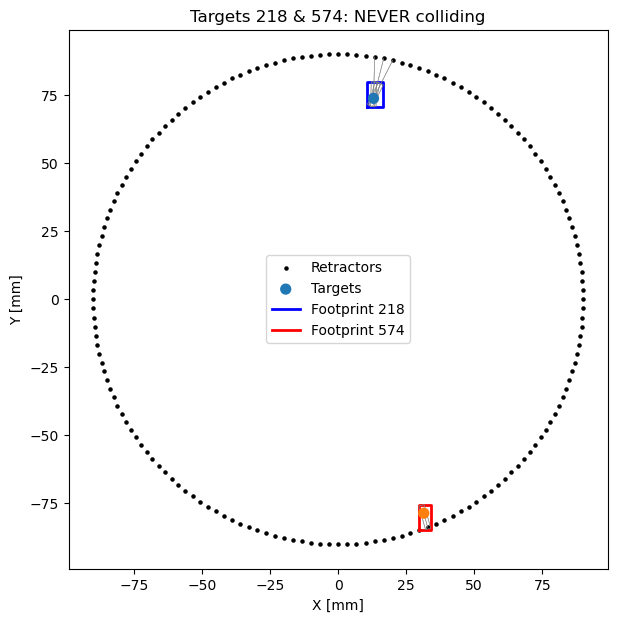

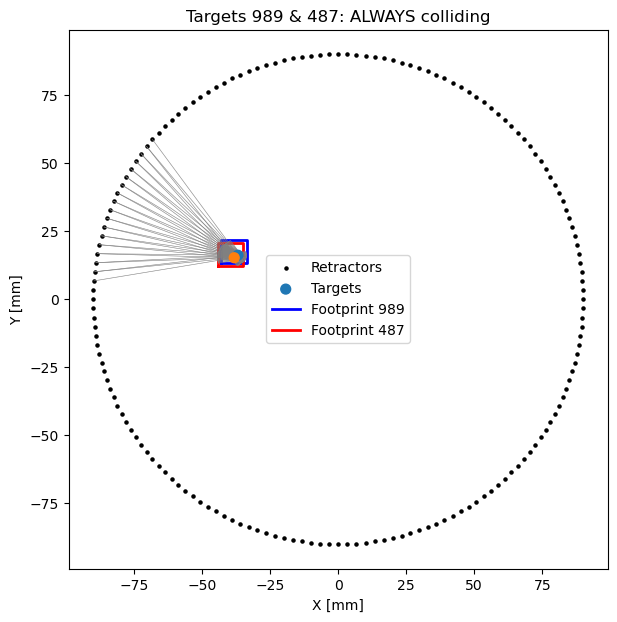

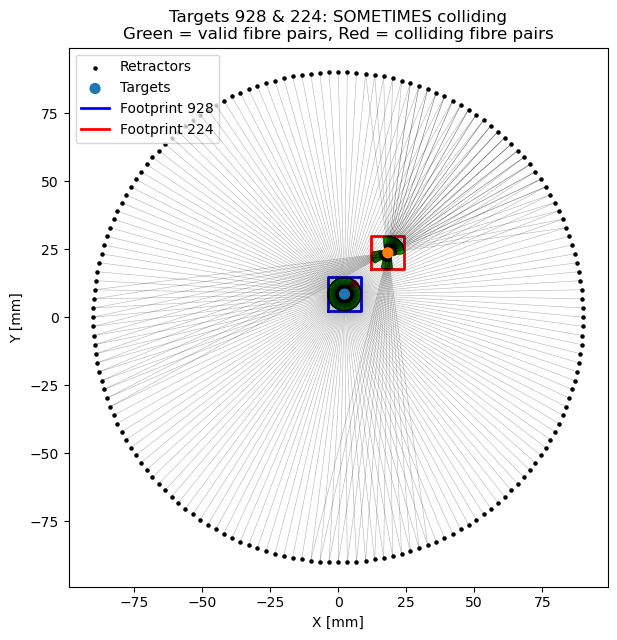

In [68]:
# NEVER colliding example

minx_np = np.asarray(xmin)
miny_np = np.asarray(ymin)
maxx_np = np.asarray(xmax)
maxy_np = np.asarray(ymax)


idxs_never = np.argwhere(collision_kind == -1)
t1, t2 = map(int, random.choice(idxs_never))
plot_never_colliding_pair(t1, t2,
                        px, py,
                        minx_np, miny_np, maxx_np, maxy_np,
                        allowed, vertices,
                        retractor_x, retractor_y,
                        n_tiers)

# ALWAYS colliding example
idxs_always = np.argwhere(collision_kind == 1)
t1, t2 = map(int, random.choice(idxs_always))
plot_always_colliding_pair(t1, t2,
                           px, py,
                           minx_np, miny_np, maxx_np, maxy_np,
                           allowed, vertices,
                           retractor_x, retractor_y,
                           n_tiers)

# SOMETIMES colliding example
idxs_some = np.argwhere(collision_kind == 0)
t1, t2 = map(int, random.choice(idxs_some))
plot_sometimes_colliding_pair(
    t1, t2,
    px, py,
    minx_np, miny_np, maxx_np, maxy_np,
    vertices,
    allowed,
    retractor_x, retractor_y,
    n_tiers,
    collision_matrix,
    reachable_fibres_per_target,
    collision_kind,
    max_combos=300,  # to avoid over-plotting
)


In [ ]:
allowed.shape # (F, T)
jnp.where(allowed[:, 84])[0] # (T,) check which fibres can reach target 16

Array([171, 172, 173], dtype=int32)

In [ ]:
fibre_rt(jnp.where(allowed[:,84])[0]) # returns retractor IDs and tier IDs

(Array([57, 57, 57], dtype=int32), Array([0, 1, 2], dtype=int32))